In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.formula.api as smf

Transform the collected study data into tables for each study:
    
 ```
 choice, labeled
 ```
 Where
 - choice is recoded as a boolean: vegan=1; vegetarian=0;
 - labeled is recoded as a boolean indicating whether respondent saw the "labeled" or "unlabeled" version: labeled=1; unlabeled=0;

In [57]:
def make_contingency_df(df):
    """
    Make tables like:
    ```
    choice, labeled, unlabeled, (%) labeled, (%) unlabeled, expected (based on unlabeled)
    0    A           B
    1    C           D
    total
    ```
    """
    contingency_df = pd.DataFrame({
        'labeled': df[df['labeled']==1]['choice'].value_counts(),
        'unlabeled': df[df['labeled']==0]['choice'].value_counts(),
    }, index=[0, 1]).rename_axis('choice').fillna(0)
    contingency_df.loc['total'] = [contingency_df[c].sum() for c in contingency_df.columns]
    for l in ['labeled', 'unlabeled']:
        contingency_df['%% %s'%l] = contingency_df[l]/contingency_df[l]['total']
    contingency_df['expected'] = (
        contingency_df['labeled']['total'] * contingency_df['% unlabeled']
    )
    return contingency_df

In [37]:
def plot_contingency_table(df, ax, legend_labels=['option 2','option 1'], ylabel=True, legend=True):
    n_labels_values = df.loc['total'][['labeled', 'unlabeled']]
    labels = ['%s\n(n=%s)'%(l, int(n)) for l, n in n_labels_values.iteritems()]
    #labels = ['labeled', 'unlabeled'] # a simpler labeling
    option1_values = 100*df[['% labeled', '% unlabeled']].loc[1]
    option2_values = 100*df[['% labeled', '% unlabeled']].loc[0]

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars
    rects1 = ax.bar(x - width/2, option1_values, width, 
                    linewidth=1, edgecolor='black',
                    color='lightgray', label=legend_labels[1])
    rects2 = ax.bar(x + width/2, option2_values, width, 
                    linewidth=1, edgecolor='black',
                    color='white', label=legend_labels[0])
    ax.set_ylim(0, 108)
    if ylabel: ax.set_ylabel('% chosen')
    ax.set_xticks(x, labels)
    option1_labels = ['%0.1f%%'%v for v in round(option1_values, 1)]
    option2_labels = ['%0.1f%%'%v for v in round(option2_values, 1)]
    ax.bar_label(rects1, option1_labels, padding=3)
    ax.bar_label(rects2, option2_labels, padding=3)
    if legend: ax.legend()

## Study 1

In [55]:
study1_df = survey_df = pd.read_csv(
    '../data/spring-2022-mas-research-talks-responses-aggregated.csv',
    usecols=[0,1,2,3,4,5]
)
print('study 1: %s total choices' % len(study1_df))
study1_df.head(3)

study 1: 53 total choices


,Timestamp,Are you...,Dinner will be served at this event. Please select the meal that you would like ordered for you.,labeled,event,choice
0,3/29/2022 17:55:49,RA,"Veggie Hummus Wrap (vegan): Hummus, greens, to...",labeled,1,vegan
1,3/29/2022 17:57:39,RA,"Greek Salad Wrap: Tomato, red onion, cucumbers...",labeled,1,vegetarian
2,3/29/2022 18:11:50,RA,"Veggie Hummus Wrap (vegan): Hummus, greens, to...",labeled,1,vegan


In [56]:
study1_df['choice'] = study1_df['choice'].apply(lambda c: 1 if c=='vegan' else 0)
study1_df['labeled'] =study1_df['labeled'].apply(lambda l: 1 if l=='labeled' else 0) 
study1_df = study1_df[['choice','labeled', 'event']]
assert(53 == len(study1_df))
study1_df.head(3)

,choice,labeled,event
0,1,1,1
1,0,1,1
2,1,1,1


chisq = 4.41; p=0.036


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,15,12,0.625,0.413793,9.931034
1,9,17,0.375,0.586207,14.068966
total,24,29,1.000,1.000000,24.000000


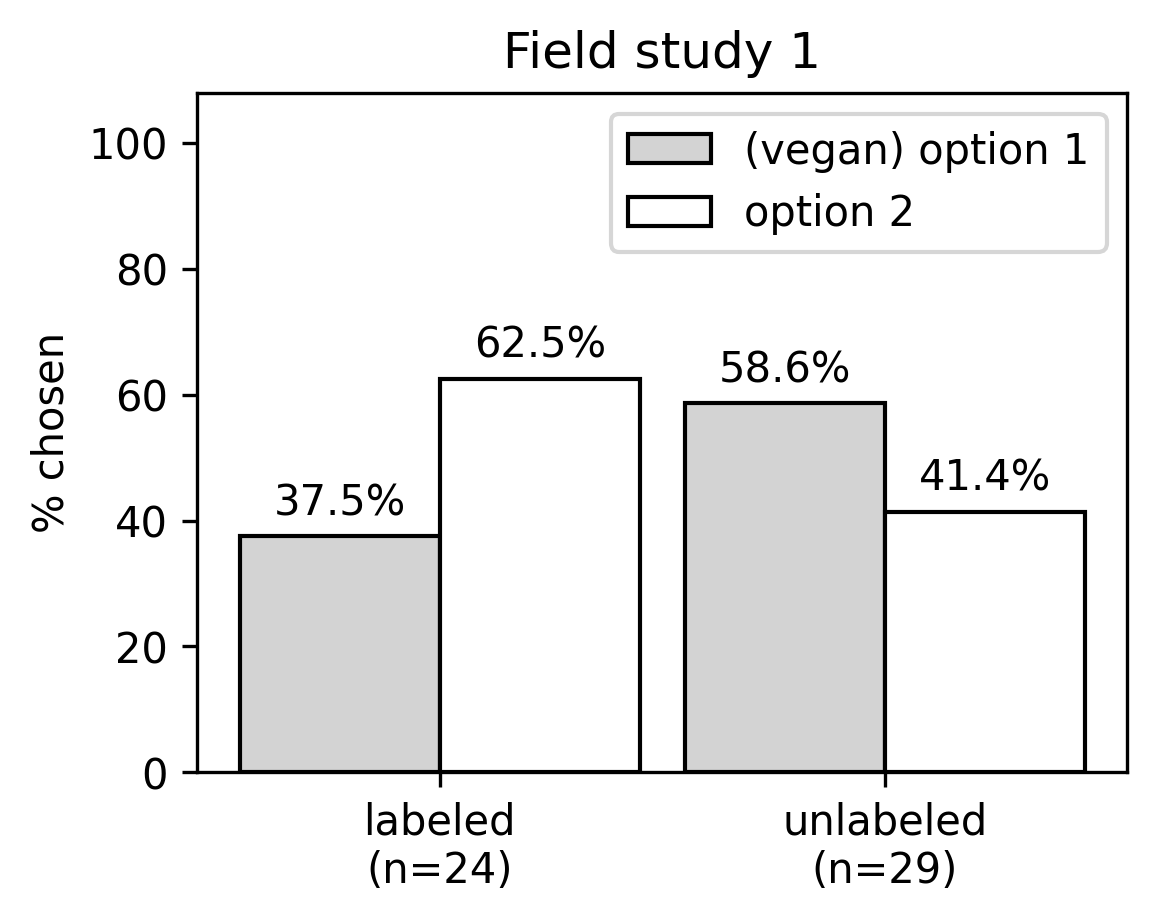

In [83]:
contingency1_df = make_contingency_df(study1_df)
figsize=(4,3)
fig,ax = plt.subplots(figsize=figsize, dpi=300)
plot_contingency_table(contingency1_df, ax, legend_labels=['option 2', '(vegan) option 1'])
chisq, p = scipy.stats.chisquare(
    contingency1_df['labeled'].drop('total'), 
    contingency1_df['expected'].drop('total')
)
print('chisq = %0.2f; p=%.3f' % (chisq, p))
ax.set_title('Field study 1')
contingency1_df

In [58]:
model1 = smf.logit("choice ~ labeled", data=study1_df).fit()
print(model1.summary())
model1_odds = pd.DataFrame(np.exp(model1.params), columns=['OR'])
model1_odds['z-value'] = model1.pvalues
model1_odds[['2.5%', '97.5%']] = np.exp(model1.conf_int())
print(model1_odds)

Optimization terminated successfully.
         Current function value: 0.670672
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                   53
Model:                          Logit   Df Residuals:                       51
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Aug 2022   Pseudo R-squ.:                 0.03218
Time:                        22:13:28   Log-Likelihood:                -35.546
converged:                       True   LL-Null:                       -36.727
Covariance Type:            nonrobust   LLR p-value:                    0.1242
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3483      0.377      0.924      0.356      -0.391       1.087
labeled       -0.8591      0.

## Study 2

In [121]:
study2_df = survey_df = pd.read_csv(
    '../data/july-2022-lab-lunch-responses-aggregated.csv',
    usecols=[0,1,2,4,5,6,7]
)
print('study 2: %s total choices' % study2_df['choice'].value_counts().sum())
study2_df.head(3)

study 2: 103 total choices


,Timestamp,Are you...,"We will order family style, with pasta dishes, gluten-free sides and salads, and treats. Please select your preferred pasta entree.",labeled,choice,vegan,vegetarian
0,6/28/2022 16:34:52,Staff,Mushroom Linguine (vegan). With broccoli rabe ...,labeled,1,0,0
1,6/28/2022 16:34:55,RA,"Cheese Ravioli. With baby arugula, parmesan, g...",labeled,2,0,0
2,6/28/2022 16:35:52,UROP,"Cheese Ravioli. With baby arugula, parmesan, g...",labeled,2,0,0


Transform choice coding to:
- 1=vegan (no change)
- 0=other (choice 2)

In [76]:
study2_df['choice'] = study2_df['choice'].apply(lambda c: 1 if c==1 else 0)
study2_df['labeled'] =study2_df['labeled'].apply(lambda l: 1 if l=='labeled' else 0) 
study2_df = study2_df[['choice','labeled']]
assert(103 == len(study2_df))
study2_df.head(3)

,choice,labeled
0,1,1
1,0,1
2,0,1


chisq = 21.69; p=0.000


,labeled,unlabeled,% labeled,% unlabeled,expected
choice,,,,,
0,37,17,0.660714,0.361702,20.255319
1,19,30,0.339286,0.638298,35.744681
total,56,47,1.000000,1.000000,56.000000


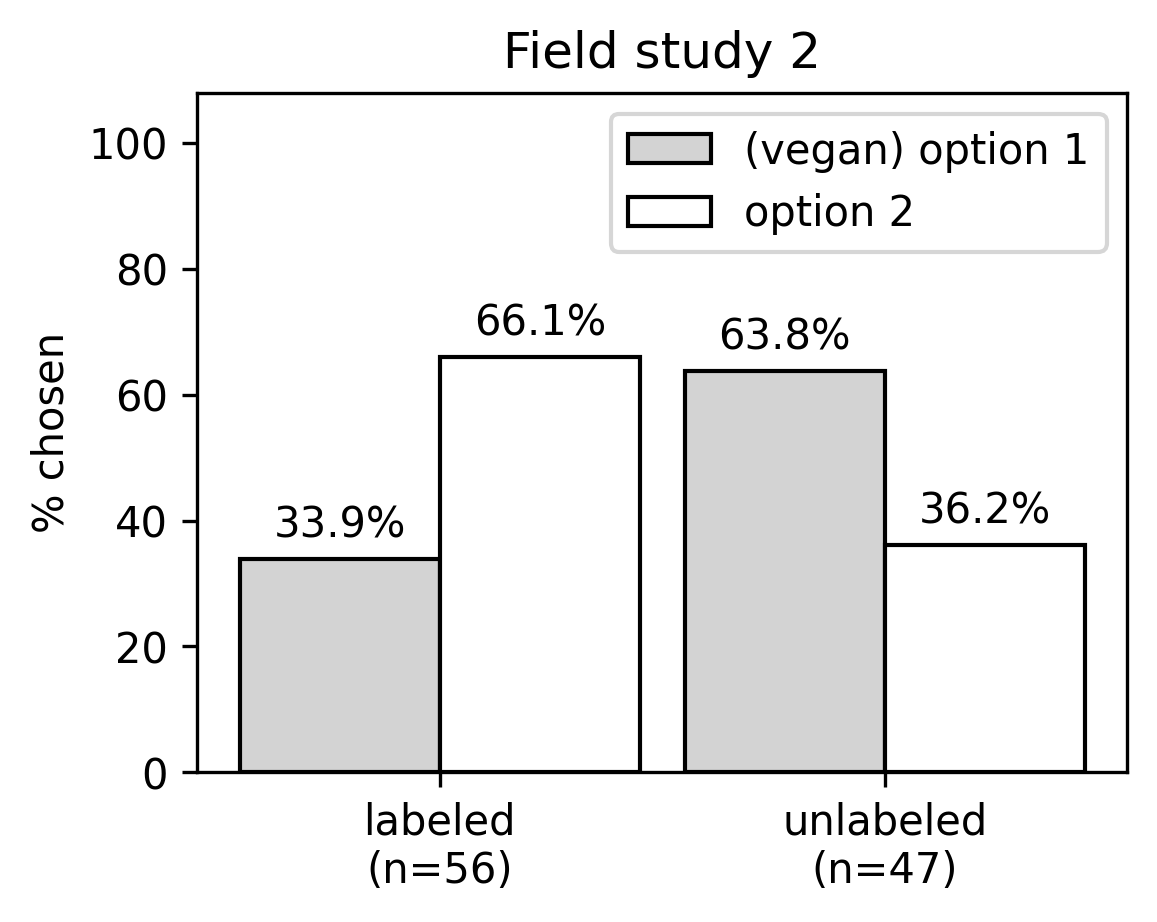

In [82]:
contingency2_df = make_contingency_df(study2_df)
figsize=(4,3)
fig,ax = plt.subplots(figsize=figsize, dpi=300)
plot_contingency_table(contingency2_df, ax, legend_labels=['option 2', '(vegan) option 1'])
chisq, p = scipy.stats.chisquare(
    contingency2_df['labeled'].drop('total'), 
    contingency2_df['expected'].drop('total')
)
print('chisq = %0.2f; p=%.3f' % (chisq, p))
ax.set_title('Field study 2')
contingency2_df

In [79]:
model2 = smf.logit("choice ~ labeled", data=study2_df).fit()
print(model2.summary())
model2_odds = pd.DataFrame(np.exp(model2.params), columns=['OR'])
model2_odds['z-value'] = model2.pvalues
model2_odds[['2.5%', '97.5%']] = np.exp(model2.conf_int())
print(model2_odds)

Optimization terminated successfully.
         Current function value: 0.646872
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  103
Model:                          Logit   Df Residuals:                      101
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Aug 2022   Pseudo R-squ.:                 0.06517
Time:                        22:27:13   Log-Likelihood:                -66.628
converged:                       True   LL-Null:                       -71.273
Covariance Type:            nonrobust   LLR p-value:                  0.002304
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5680      0.304      1.871      0.061      -0.027       1.163
labeled       -1.2345      0.

Field study 2 asked participants whether they had dietary restrictions, where they could select vegetarian and/or vegan. 
What happened here? Did vegans select non-vegan options when the labels were removed?

In [131]:
# How many vegans and vegetarians?
print('%s vegetarians' % study2_df['vegetarian'].sum())
print('%s vegans' % study2_df['vegan'].sum())
print('%s selected both vegan and vegetarian' % (study2_df['vegan']+study2_df['vegetarian'] == 2).sum())

18 vegetarians
5 vegans
0 selected both vegan and vegetarian


In [132]:
study2_vegan_df = study2_df[study2_df['vegan']==1]
study2_vegan_df

,Timestamp,Are you...,"We will order family style, with pasta dishes, gluten-free sides and salads, and treats. Please select your preferred pasta entree.",labeled,choice,vegan,vegetarian
7,6/28/2022 16:40:01,RA,Mushroom Linguine (vegan). With broccoli rabe ...,labeled,1,1,0
8,6/28/2022 16:42:43,RA,Mushroom Linguine (vegan). With broccoli rabe ...,labeled,1,1,0
12,6/28/2022 17:03:48,UROP,Mushroom Linguine (vegan). With broccoli rabe ...,labeled,1,1,0
91,7/8/2022 14:15:26,Intern,"Cheese Ravioli. With baby arugula, parmesan, g...",labeled,2,1,0
93,7/8/2022 16:06:53,MSRP,Mushroom Linguine (vegan). With broccoli rabe ...,labeled,1,1,0


All of the vegans were in the labeled condition AND one selected the non-vegan option...

### Calculating the odds ratio (OR) with 95% CIs

(Same result as binary logistic regression above)

In [107]:
# https://zepid.readthedocs.io/en/latest/Reference/generated/zepid.base.OddsRatio.html
from zepid import OddsRatio

Comparison:0 to 1
+-----+-------+-------+
|     |   D=1 |   D=0 |
+=====+=======+=======+
| E=1 |     9 |    15 |
+-----+-------+-------+
| E=0 |    17 |    12 |
+-----+-------+-------+ 

                           Odds Ratio                                 
       OddsRatio  SD(OR)  OR_LCL  OR_UCL
Ref:0      1.000     NaN     NaN     NaN
1          0.424   0.566    0.14   1.283
----------------------------------------------------------------------
Missing E:    0
Missing D:    0
Missing E&D:  0


/Users/aberke/projects/ff/venv-ff/lib/python3.7/site-packages/zepid/base.py:1238: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


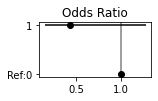

In [120]:
# Note this does not indicate statistical significance, since OR 95% CI spans 1.
ort1 = OddsRatio()
ort1.fit(study1_df, exposure='labeled',outcome='choice')
fig,ax = plt.subplots(figsize=(2,1))
_ = ort1.plot()
ort1.summary()

/Users/aberke/projects/ff/venv-ff/lib/python3.7/site-packages/zepid/base.py:1238: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


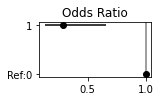

Comparison:0 to 1
+-----+-------+-------+
|     |   D=1 |   D=0 |
+=====+=======+=======+
| E=1 |    19 |    37 |
+-----+-------+-------+
| E=0 |    30 |    17 |
+-----+-------+-------+ 

                           Odds Ratio                                 
       OddsRatio  SD(OR)  OR_LCL  OR_UCL
Ref:0      1.000     NaN     NaN     NaN
1          0.291   0.415   0.129   0.656
----------------------------------------------------------------------
Missing E:    0
Missing D:    0
Missing E&D:  0


In [119]:
ort2 = OddsRatio()
ort2.fit(study2_df, exposure='labeled',outcome='choice')
fig,ax = plt.subplots(figsize=(2,1))
_ = ort2.plot()
plt.show()
ort2.summary()